In [41]:
# Test for the estimation of a single image key-points

import argparse
import grpc
import io
import matplotlib.pyplot as plt
from importlib.machinery import SourceFileLoader
image_generic_pb2 = SourceFileLoader("image_generic_pb2","../protos/image_generic_pb2.py").load_module()
image_generic_pb2_grpc = SourceFileLoader("image_generic_pb2_grpc","../protos/image_generic_pb2_grpc.py").load_module()
#import ../protos/image_generic_pb2
#import ../protos/image_generic_pb2_grpc
import PIL.Image as PIL_image
import numpy as np
import cv2

In [52]:
def process_image(stub, image_path):
    print(f'Processing image: \'{image_path}\'')
    with open(image_path, 'rb') as fp:
        image_bytes = fp.read()
    request = image_generic_pb2.Image(data=image_bytes)
    return stub.process(request)


def display_image(image):
    img = PIL_image.open(io.BytesIO(image.data))
    ax = plt.gca()
    ax.imshow(img)
    plt.show()

def plot_features(img,kp):
    for p in kp:
        cv2.circle(img,(int(p[0]),int(p[1])), 3, (0,0,255), -1)
    ax =plt.gca()
    ax.imshow(img)
    plt.show()

def parse_args():
    """
    Parse arguments for test setup

    Returns:
        The arguments for the test
    """
    parser = argparse.ArgumentParser(description='Test for OpenPose gRPC Service')
    parser.add_argument(
        'image',
        help='Path to the image to send to the server')
    parser.add_argument(
        '--target',
        metavar='target',
        default='10.0.14.4:8061',
        help='Location of the tested server (defaults to localhost:8061)')
    return parser.parse_args()

Processing image: '/home/jovyan/pipelines/opencvsimple/imagedelay-grpc-service/images/golf.jpg'


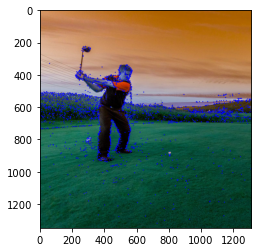

In [53]:
target='10.0.14.4:8061'
image_path='/home/jovyan/pipelines/opencvsimple/imagedelay-grpc-service/images/golf.jpg'
with grpc.insecure_channel(target) as channel:
    estimator_stub = image_generic_pb2_grpc.ImageGenericServiceStub(channel)
    response = process_image(estimator_stub, image_path)
kp=np.frombuffer(response.coords,dtype='float32').reshape(response.numfeatures,2)
desc=np.frombuffer(response.descriptors,dtype='float32').reshape(response.numfeatures,128)
img=cv2.imdecode(np.frombuffer(response.img.data,dtype='uint8'), cv2.IMREAD_COLOR)
plot_features(img,kp)

In [54]:
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp,desc = sift.detectAndCompute(gray,None)    


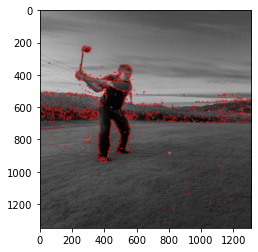

In [56]:
output_image = cv2.drawKeypoints(gray,kp, 0, (255, 0, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
plt.imshow(output_image)
plt.show()

In [ ]:
if __name__ == '__main__':
    args = parse_args()
    target = args.target
    image_path = args.image
    with grpc.insecure_channel(target) as channel:
        estimator_stub = image_generic_pb2_grpc.ImageGenericServiceStub(channel)
        try:
            response = process_image(estimator_stub, image_path)
            display_image(response)
        except grpc.RpcError as rpc_error:
            print('An error has occurred:')
            print(f'  Error Code: {rpc_error.code()}')
            print(f'  Details: {rpc_error.details()}')